In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient
import os

# 1. 폰트 설정 및 라이브러리 import

In [2]:
from common import (
    sensor_types, sensor_type_mapping,
    get_influx_client, 
)


# 2. Influx DB 

In [4]:
# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()


# Flux 쿼리 작성
flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -24h)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["location"] == "입구")
  |> filter(fn: (r) => r["type"] == "activity" or r["type"] == "co2" or r["type"] == "humidity" or r["type"] == "infrared_and_visible" or r["type"] == "temperature" or r["type"] == "tvoc" or r["type"] == "pressure" or r["type"] == "infrared" or r["type"] == "illumination")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)

if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"})
df = df.set_index("time")

# 데이터 확인
print("데이터 샘플:")
display(df.head())
print(f"데이터 크기: {df.shape}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -24h)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["location"] == "입구")
  |> filter(fn: (r) => r["type"] == "activity" or r["type"] == "co2" or r["type"] == "humidity" or r["type"] == "infrared_and_visible" or r["type"] == "temperature" or r["type"] == "tvoc" or r["type"] == "pressure" or r["type"] == "infrared" or r["type"] == "illumination")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings

데이터 샘플:


,index,result,table,_start,_stop,_value,_field,_measurement,location,type
time,,,,,,,,,,
2025-04-24 02:30:00+00:00,0,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,11.500000,value,sensor,입구,activity
2025-04-24 02:35:00+00:00,1,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,12.600000,value,sensor,입구,activity
2025-04-24 02:40:00+00:00,2,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,20.250000,value,sensor,입구,activity
2025-04-24 04:25:00+00:00,3,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,4.250000,value,sensor,입구,activity
2025-04-24 04:30:00+00:00,4,mean,0,2025-04-24 02:27:59.007898+00:00,2025-04-25 02:27:59.007898+00:00,6.333333,value,sensor,입구,activity


데이터 크기: (2412, 10)


In [10]:
pivot_df = df.pivot_table(
    index=['time', 'location'],
    columns='type',
    values='_value'
).reset_index()

pivot_df = pivot_df.set_index('time')

# 인덱스 초기화하여 중복 문제 해결
pivot_df_reset = pivot_df.reset_index(drop=False).copy()

# 분석할 환경 변수 목록
env_vars = ['temperature', 'humidity', 'co2', 'tvoc', 'pressure']
available_vars = [var for var in env_vars if var in pivot_df_reset.columns]

## 온도와 활동량

활동량과 온도의 상관계수: -0.1688
해석: 활동량과 온도 사이에는 음의 약한 상관관계가 있습니다.
이는 활동량이 증가할수록 온도는 감소함을 의미합니다.


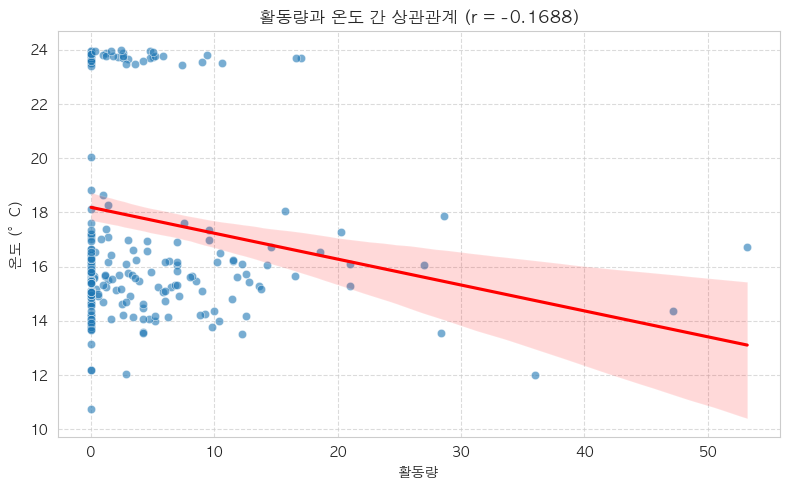

In [11]:
# 온도와 활동량 상관관계 분석
corr_temp_activity = pivot_df_reset[['activity', 'temperature']].corr().iloc[0, 1]
print(f"활동량과 온도의 상관계수: {corr_temp_activity:.4f}")

# 상관관계 해석
if abs(corr_temp_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_temp_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_temp_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 온도 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 온도도 증가' if corr_temp_activity > 0 else '증가할수록 온도는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='temperature', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='temperature', scatter=False, color='red')
plt.title(f'활동량과 온도 간 상관관계 (r = {corr_temp_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('온도 (°C)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_temperature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## 습도와 활동량

활동량과 습도의 상관계수: 0.2262
해석: 활동량과 습도 사이에는 양의 약한 상관관계가 있습니다.
이는 활동량이 증가할수록 습도도 증가함을 의미합니다.


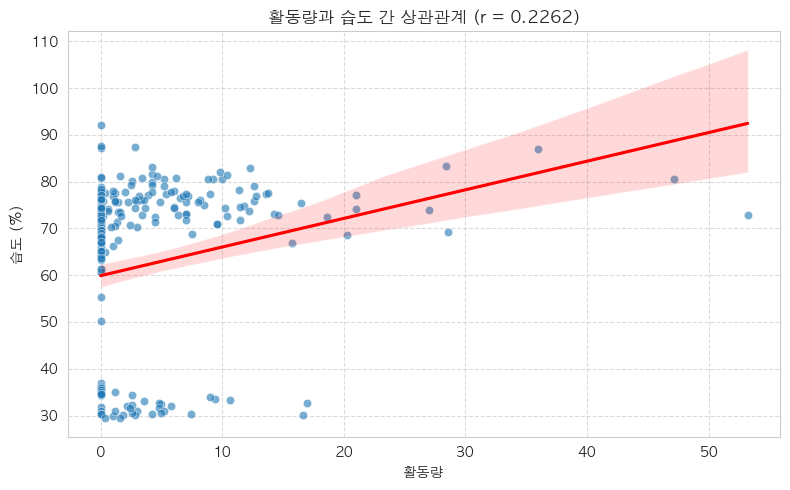

In [12]:
# 습도와 활동량 상관관계 분석
corr_humidity_activity = pivot_df_reset[['activity', 'humidity']].corr().iloc[0, 1]
print(f"활동량과 습도의 상관계수: {corr_humidity_activity:.4f}")

# 상관관계 해석
if abs(corr_humidity_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_humidity_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_humidity_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 습도 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 습도도 증가' if corr_humidity_activity > 0 else '증가할수록 습도는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='humidity', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='humidity', scatter=False, color='red')
plt.title(f'활동량과 습도 간 상관관계 (r = {corr_humidity_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('습도 (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_humidity_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## Co2 활동량

활동량과 CO₂의 상관계수: 0.5648
해석: 활동량과 CO₂ 사이에는 양의 중간 정도의 상관관계가 있습니다.
이는 활동량이 증가할수록 CO₂도 증가함을 의미합니다.


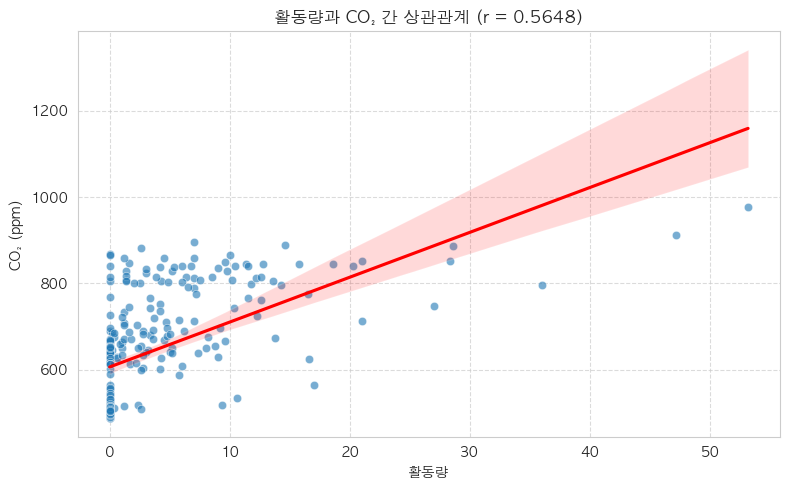

In [13]:
# CO₂와 활동량 상관관계 분석
corr_co2_activity = pivot_df_reset[['activity', 'co2']].corr().iloc[0, 1]
print(f"활동량과 CO₂의 상관계수: {corr_co2_activity:.4f}")

# 상관관계 해석
if abs(corr_co2_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_co2_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_co2_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 CO₂ 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 CO₂도 증가' if corr_co2_activity > 0 else '증가할수록 CO₂는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='co2', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='co2', scatter=False, color='red')
plt.title(f'활동량과 CO₂ 간 상관관계 (r = {corr_co2_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('CO₂ (ppm)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_co2_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## TVOC : 총 휘발성 유기 화합물(Total Volatile Organic Compounds)과 활동량

활동량과 TVOC의 상관계수: 0.3676
해석: 활동량과 TVOC 사이에는 양의 중간 정도의 상관관계가 있습니다.
이는 활동량이 증가할수록 TVOC도 증가함을 의미합니다.


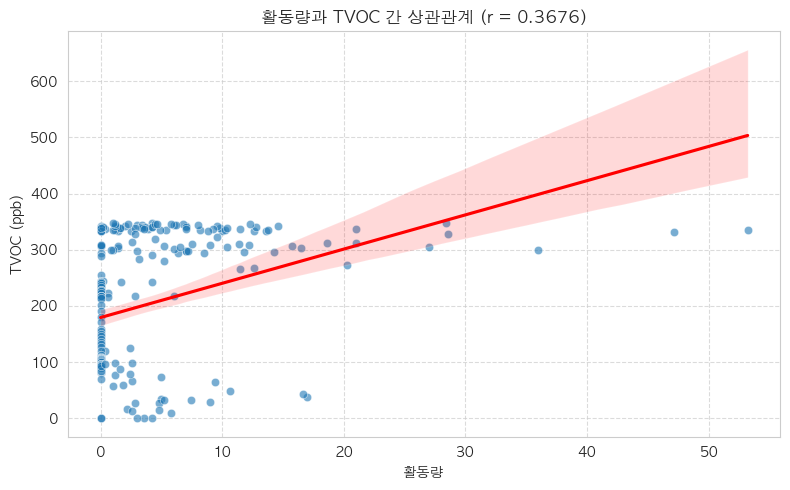

In [14]:
# TVOC와 활동량 상관관계 분석
corr_tvoc_activity = pivot_df_reset[['activity', 'tvoc']].corr().iloc[0, 1]
print(f"활동량과 TVOC의 상관계수: {corr_tvoc_activity:.4f}")

# 상관관계 해석
if abs(corr_tvoc_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_tvoc_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_tvoc_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 TVOC 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 TVOC도 증가' if corr_tvoc_activity > 0 else '증가할수록 TVOC는 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='tvoc', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='tvoc', scatter=False, color='red')
plt.title(f'활동량과 TVOC 간 상관관계 (r = {corr_tvoc_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('TVOC (ppb)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_tvoc_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


## 압력과 활동량

활동량과 압력의 상관계수: -0.3450
해석: 활동량과 압력 사이에는 음의 중간 정도의 상관관계가 있습니다.
이는 활동량이 증가할수록 압력은 감소함을 의미합니다.


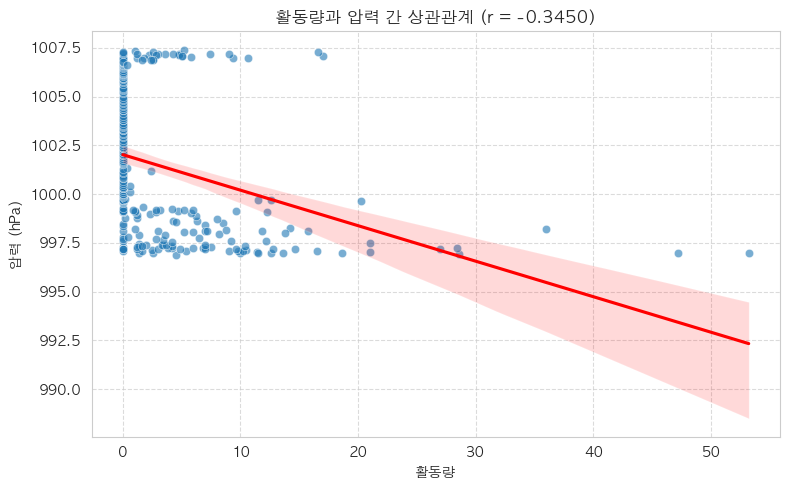

In [15]:
# 압력과 활동량 상관관계 분석
corr_pressure_activity = pivot_df_reset[['activity', 'pressure']].corr().iloc[0, 1]
print(f"활동량과 압력의 상관계수: {corr_pressure_activity:.4f}")

# 상관관계 해석
if abs(corr_pressure_activity) < 0.3:
    interpretation = "약한 상관관계"
elif abs(corr_pressure_activity) < 0.7:
    interpretation = "중간 정도의 상관관계"
else:
    interpretation = "강한 상관관계"
    
if corr_pressure_activity > 0:
    direction = "양의"
else:
    direction = "음의"
    
print(f"해석: 활동량과 압력 사이에는 {direction} {interpretation}가 있습니다.")
print(f"이는 활동량이 {'증가할수록 압력도 증가' if corr_pressure_activity > 0 else '증가할수록 압력은 감소'}함을 의미합니다.")

# 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pivot_df_reset, x='activity', y='pressure', alpha=0.6)
sns.regplot(data=pivot_df_reset, x='activity', y='pressure', scatter=False, color='red')
plt.title(f'활동량과 압력 간 상관관계 (r = {corr_pressure_activity:.4f})')
plt.xlabel('활동량')
plt.ylabel('압력 (hPa)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/activity_pressure_correlation.png', dpi=300, bbox_inches='tight')
plt.show()
